In [1]:
# Common
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi
import pandas as pd
import cv2
import os

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Data Aug
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom


# Model
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten

# Compiling
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow_addons.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc

/Users/saptarshimallikthakur/miniconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Fixing the lighting of images

Histogram Equalization is an image processing technique that adjusts the contrast of an image by using its histogram. 

To enhance the image’s contrast, it spreads out the most frequent pixel intensity values or stretches out the intensity range of the image.

This helps in equalising the irregular lighting of an image.

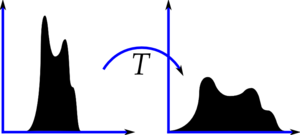

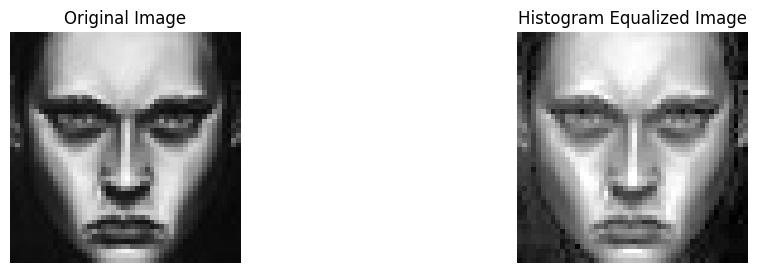

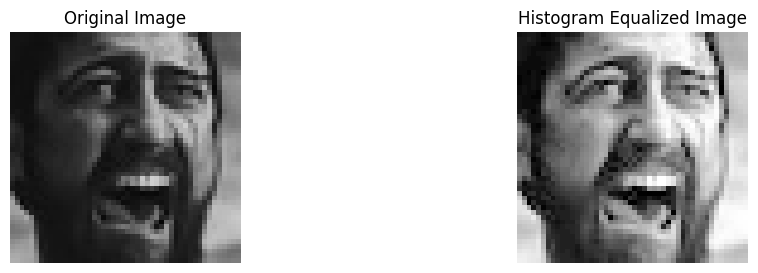

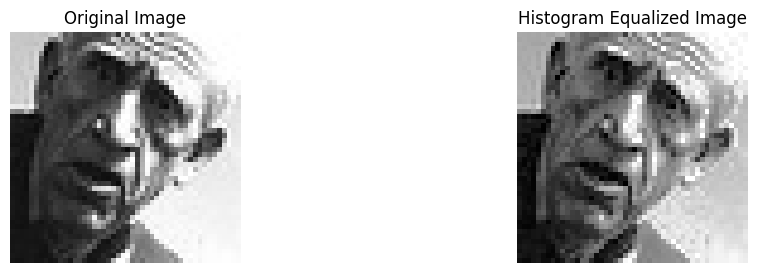

In [2]:
def display_histogram_equalized_images(image_list):
    for idx, img in enumerate(image_list):
        
        image = cv2.imread(img)
        # Convert the image from BGR color space to YUV color space
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        
        # Equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        
        # Convert the YUV image back to BGR format
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        
        # Create a figure to display the images
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        
        # Display the original image
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Display the output image after histogram equalization
        axes[1].imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Histogram Equalized Image")
        axes[1].axis('off')
        
        # Display the images
        plt.show()
        
display_histogram_equalized_images(['/Users/saptarshimallikthakur/Movies/VIT/archive/test/angry/PrivateTest_1290484.jpg',
                                   '/Users/saptarshimallikthakur/Movies/VIT/archive/test/angry/PrivateTest_1488292.jpg',
                                    '/Users/saptarshimallikthakur/Movies/VIT/archive/test/surprise/PrivateTest_25271151.jpg'])

### Data Augmentation 

We shear and rotate the image.

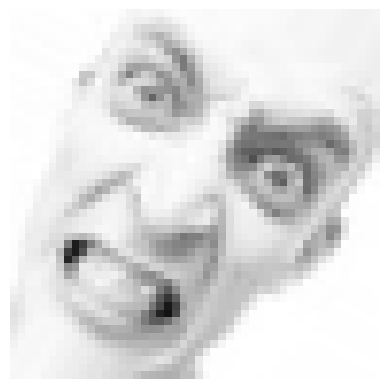

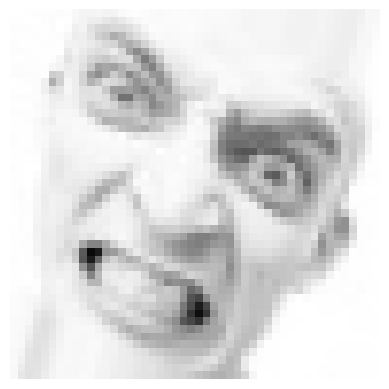

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=50,  # Random rotation within the range of -50 to +50 degrees
    shear_range=25,     # Random shear transformation
    fill_mode='nearest' # Filling mode for newly created pixels (nearest neighbor)
)

face_image = cv2.imread('/Users/saptarshimallikthakur/Movies/VIT/archive/test/angry/PrivateTest_98403294.jpg')

# Load the original image (assuming 'face_image' is already loaded)
img = face_image.copy() / 255  # Normalize pixel values to the range [0, 1]

# Reshape the image to a 4D tensor with shape (1, height, width, channels)
img = img.reshape((1,) + img.shape)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(img, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 2:
        break  # Stop the loop after generating 2 augmented images

# Display the original and augmented images
for i, img in enumerate(augmented_images):
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

### Mimicking Facial Occlusion and Accessories 

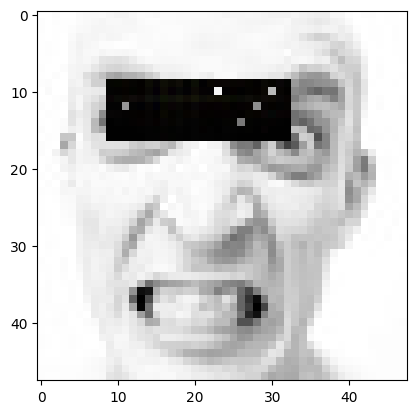

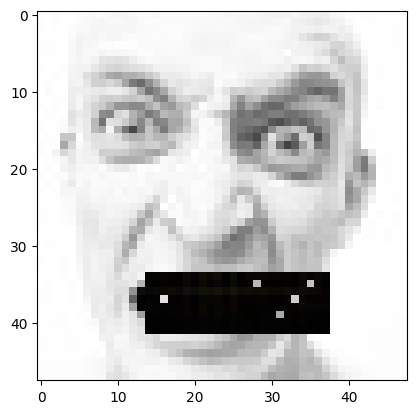

In [4]:
# Load the face image and black image
face_image = cv2.imread('/Users/saptarshimallikthakur/Movies/VIT/archive/test/angry/PrivateTest_98403294.jpg')
glasses_image = cv2.imread('black.jpg')

# Resize the glasses image to a smaller size (e.g., 8x8)
glasses_resized = cv2.resize(glasses_image, (24, 8))

# Randomly select positions for overlaying the glasses
x_pos, y_pos = np.random.randint(5, 10), np.random.randint(5, 15)

# Overlay the glasses on the face image
for _ in range(2):
    face_images = face_image.copy()
    for i in range(glasses_resized.shape[0]):
        for j in range(glasses_resized.shape[1]):
            if glasses_resized[i, j, 0] > 0:  # Check if the pixel is not transparent (using the red channel)
                face_images[y_pos + i, x_pos + j, :] = glasses_resized[i, j, :3]

    # Display the modified face image with glasses
    plt.imshow(face_images)
    plt.show()

    # Update positions for the next iteration
    y_pos += 25
    x_pos += 5

### Load the images and apply lighting fixation, data augmentation and artificial occlussion.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=50,
    shear_range=25,
    fill_mode='nearest'
)

# Define the path to the main directory containing image data
main_dir = "/Users/saptarshimallikthakur/Movies/VIT/archive/train/"

# List of subdirectories (labels)
labels = os.listdir(main_dir)

# Initialize lists to hold images and their corresponding labels
images = []
image_labels = []

# Loop through each label (subdirectory)
for label in labels:
    
    print(label)
    
    label_dir = os.path.join(main_dir, label)
    
    if os.path.isdir(label_dir):
        
        # Loop through each image file in the label directory
        for file_name in os.listdir(label_dir)[:2000]:
            file_path = os.path.join(label_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                
                # Read the image file using cv2
                image = cv2.imread(file_path)
                
                if image is not None:
                    
                    # Convert the image from BGR to YUV color space
                    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

                    # Equalize the histogram of the Y channel
                    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

                    # Convert the YUV image back to RGB format
                    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)/255
                   
                    images.append(img_output)
                    image_labels.append(label)
                    
                    #------------------------------------------------------------------------------------------------------------------
                    
                    # Reshape the image to a 4D tensor with shape (1, height, width, channels)
                    img = img_output.reshape((1,) + img_output.shape)
                    # Generate augmented images
                    augmented_images = []
                    for batch in datagen.flow(img, batch_size=1):
                        augmented_images.append(batch[0])
                        if len(augmented_images) >= 2:
                            break 

                    glasses_image = cv2.imread('black.jpg')
                    glasses_resized = cv2.resize(glasses_image, (24, 8))
                    
                    for imgs in augmented_images:
                        images.append(imgs)
                        image_labels.append(label)
                        
                    #----------------------------------------------------------------------------------------------------------------
                     
                    # Randomly select a position on the face (you can adjust this based on your preference)
                    x_pos, y_pos = np.random.randint(10,20),np.random.randint(20,30) 
                    
                    for imgs in augmented_images:                    
                    
                        face_images = imgs.copy()
        
                        # Overlay the glasses on the face
                        for i in range(glasses_resized.shape[0]):
                            for j in range(glasses_resized.shape[1]):
                                if glasses_resized[i, j, 0] >0:  # Check if the pixel is not transparent (using the red channel)
                                    face_images[y_pos + i, x_pos + j, :] = glasses_resized[i, j, :3]

                        images.append(face_images)
                        image_labels.append(label)  
                        
                        x_pos+=5
                        y_pos+=10

# Convert lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Print the number of images and labels loaded
print(f"Loaded {len(images)} images with corresponding labels.")

happy
.DS_Store
sad
fear
surprise
neutral
angry
disgust
Loaded 62180 images with corresponding labels.


## Example

Visualising our augmented images

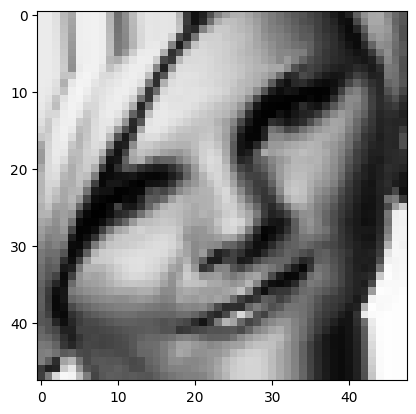

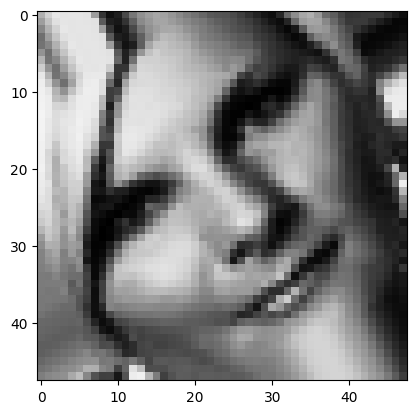

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


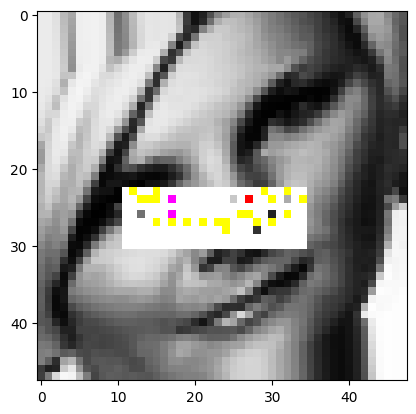

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


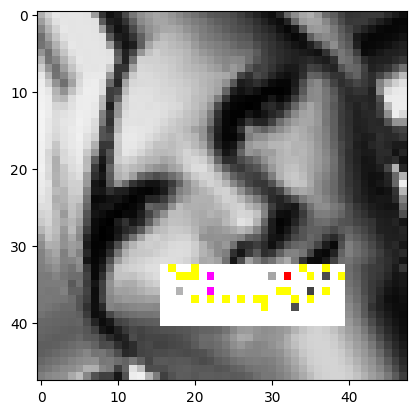

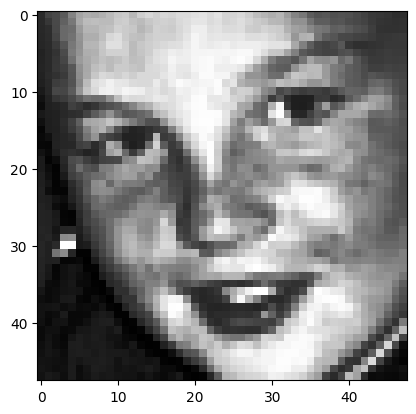

In [6]:
i = 6

for j in range(5):
    plt.imshow(images[i+j])
    plt.show()

In [7]:
from collections import Counter

Counter(image_labels)

Counter({'happy': 10000,
         'sad': 10000,
         'fear': 10000,
         'surprise': 10000,
         'neutral': 10000,
         'angry': 10000,
         'disgust': 2180})

In [8]:
maps = {'happy':0,'sad':1,'neutral':2,'fear':3,'angry':4,'surprise':5,'disgust':6}

new_labels = np.vectorize(lambda x: maps.get(x))(image_labels)
new_labels = np.array([[i] for i in new_labels])
new_labels.shape

(62180, 1)

### Building the Model

In [9]:
SIZE = 48
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 100
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [2048,1024]

In [10]:
def patches(images, patch_size):
    
    # Get the batch size
    batch_size = tf.shape(images)[0]

    # Extract patches from the input images
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],  # Only along the Height and Width dimensions
        strides=[1, patch_size, patch_size, 1],  # The next patch should not overlap the previous patch
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Determine the number of dimensions in each patch
    patch_dims = patches.shape[-1]

    # Reshape the patches to have the desired format
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])

    return patches

Here's what each part of the code does:

1. **Batch Size Calculation**:
   - `batch_size = tf.shape(images)[0]`: This line computes the batch size by extracting the first dimension of the `images` tensor. It assumes that the input `images` are organized as a batch of images.

2. **Patch Extraction**:
   - `tf.image.extract_patches` extracts patches from the input images.
   - `images=images`: The input image tensor.
   - `sizes=[1, patch_size, patch_size, 1]`: Specifies the patch size along the height and width dimensions (ignoring the batch and channel dimensions).
   - `strides=[1, patch_size, patch_size, 1]`: Determines the step size for moving the patch window. In this case, it ensures non-overlapping patches.
   - `rates=[1, 1, 1, 1]`: Specifies the dilation rate (no dilation here).
   - `padding='VALID'`: Patches are only extracted from valid regions (no padding).

3. **Patch Dimensions**:
   - `patch_dims = patches.shape[-1]`: This line calculates the number of dimensions in each patch. The last dimension of the `patches` tensor corresponds to the patch dimensions.

4. **Reshaping Patches**:
   - `patches = tf.reshape(patches, [batch_size, -1, patch_dims])`: The patches are reshaped into a 3D tensor with dimensions `[batch_size, num_patches, patch_dims]`. The `-1` in the second dimension allows TensorFlow to infer the correct size based on the other dimensions.

In [11]:
def patch_encoder(X, num_patches, projection_dims):
    
    # Create a tensor with positions ranging from 0 to num_patches-1
    positions = tf.range(0, limit=num_patches, delta=1)

    # Initialize a dense layer with 'projection_dims' units
    dense_layer = Dense(units=projection_dims)

    # Apply the dense layer to the input 'X' and add positional embeddings
    encoded = dense_layer(X) + Embedding(input_dim=num_patches, output_dim=projection_dims)(positions)

    return encoded

Here's what each section of the code does:

1. **Positional Encoding**:
   - `positions = tf.range(0, limit=num_patches, delta=1)`: This line creates a tensor containing integer values from 0 to `num_patches-1`. These values represent the positions of the patches.

2. **Dense Layer Initialization**:
   - `dense_layer = Dense(units=projection_dims)`: A dense (fully connected) layer is initialized with `projection_dims` units. This layer will be applied to the input tensor `X`.

3. **Encoding Process**:
   - `dense_layer(X)`: The input tensor `X` is passed through the dense layer. This operation applies a linear transformation to the input features.
   - `Embedding(input_dim=num_patches, output_dim=projection_dims)(positions)`: An embedding layer is created with vocabulary size `num_patches` and embedding dimension `projection_dims`. The embedding layer maps each position index to a learnable vector representation.
   - The output of the dense layer and the positional embeddings are added element-wise to obtain the final encoded representation.

4. **Output**:
   - The function returns the encoded tensor.

This function combines learned features from the dense layer with positional information using embeddings. It's commonly used in transformer-based architectures for natural language processing and other sequence-to-sequence tasks.

In [12]:
def gelu(x):
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
    return x * cdf

def mlp(x, units, rate):
    for unit in units:
        x = Dense(unit, activation=gelu)(x)
        x = Dropout(rate)(x)
    return x

def transformer(X, L, num_heads, key_dims, hidden_units):
    inputs = X
    x = X
    norm = LayerNormalization(epsilon=1e-6)
    add = Add()

    for _ in range(L):
        x = norm(x)
        x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)(x,x)
        y = add([x, inputs])
        x = norm(y)
        x = mlp(x, hidden_units, rate=0.1)
        x = add([x, y])

    return x

In [13]:
# Input Layer
inputs = Input(shape=(48,48,3))

# Get Patches
x = patches(inputs,PATCH_SIZE)

# PatchEncoding Network
x = patch_encoder(x,NUM_PATCHES, PROJECTION_DIMS)

# Transformer Network
x = transformer(x,8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)

# Output Network
x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = mlp(x,OUTPUT_UNITS, rate=0.5)

# Ouput Layer
outputs = Dense(7)(x)

2024-06-01 16:50:39.939823: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-01 16:50:39.939837: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-06-01 16:50:39.939840: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-06-01 16:50:39.939865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-01 16:50:39.939877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
pip freeze > requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [13]:
with tf.device('/GPU:0'):
  # Model
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  # Compiling
  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=['accuracy']
  )

  # Fit
  results = model.fit(
      images,new_labels,
      epochs=50
  )

model.save('my_model.h5')

Epoch 1/50


2024-05-31 23:19:08.744295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1944/1944 [==============================] - 453s 229ms/step - loss: 1.2056 - accuracy: 0.5570
Epoch 2/50
1944/1944 [==============================] - 451s 232ms/step - loss: 1.1443 - accuracy: 0.5797
Epoch 3/50
1944/1944 [==============================] - 447s 230ms/step - loss: 1.0889 - accuracy: 0.6041
Epoch 4/50
1944/1944 [==============================] - 443s 228ms/step - loss: 1.0515 - accuracy: 0.6219
Epoch 5/50
1944/1944 [==============================] - 442s 227ms/step - loss: 1.0067 - accuracy: 0.6376
Epoch 6/50
1944/1944 [==============================] - 439s 226ms/step - loss: 0.9832 - accuracy: 0.6464
Epoch 7/50
1944/1944 [==============================] - 449s 231ms/step - loss: 0.9514 - accuracy: 0.6608
Epoch 8/50
1944/1944 [==============================] - 457s 235ms/step - loss: 0.9324 - accuracy: 0.6692
Epoch 9/50
1944/1944 [==============================] - 439s 226ms/step - loss: 0.8986 - accuracy: 0.6803
Epoch 10/50
1944/1944 [==============================] - 

/Users/saptarshimallikthakur/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# LOAD THE SAVED MODEL

Models=tf.keras.models.load_model('my_model.h5')

### TESTING THE MODEL ON TEST DATA

In [15]:
# Define the path to the main directory
main_dir = "/Users/saptarshimallikthakur/Movies/VIT/archive/test/"

# List of subdirectories (labels)
labels = os.listdir(main_dir)

# Initialize lists to hold images_test and their corresponding labels
images_test = []
image_labels_test = []

# Loop through each label (subdirectory)
for label in labels:
    label_dir = os.path.join(main_dir, label)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                # Read the image file using cv2
                image = cv2.imread(file_path)
                if image is not None:
                    
                    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

                    # equalize the histogram of the Y channel
                    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

                    # convert the YUV image back to RGB format
                    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

                    images_test.append(img_output/255)
                    image_labels_test.append(label)

# Convert lists to numpy arrays
images_test = np.array(images_test)
image_labels_test = np.array(image_labels_test)

# Print the number of images_test and labels loaded
print(f"Loaded {len(images_test)} images_test with corresponding labels.")


Loaded 7178 images_test with corresponding labels.


In [23]:
predictions = Models.predict(images_test)

def get_predicted_index(logits):
    return np.argmax(logits)

predicted_indices = np.apply_along_axis(get_predicted_index, axis=1, arr=predictions)

maps = {'happy':0,'sad':1,'neutral':2,'fear':3,'angry':4,'surprise':5,'disgust':6}
reverse_maps = {v: k for k, v in maps.items()}

emotions = [reverse_maps[num] for num in predicted_indices]


from sklearn.metrics import classification_report
print(classification_report(image_labels_test, emotions))

225/225 [==============================] - 22s 96ms/step
              precision    recall  f1-score   support

       angry       0.33      0.34      0.34       958
     disgust       0.84      0.33      0.48       111
        fear       0.35      0.24      0.28      1024
       happy       0.60      0.56      0.58      1774
     neutral       0.35      0.49      0.41      1233
         sad       0.31      0.34      0.32      1247
    surprise       0.64      0.54      0.58       831

    accuracy                           0.43      7178
   macro avg       0.49      0.40      0.43      7178
weighted avg       0.44      0.43      0.43      7178



### Classification Report Visualisation of Model Prediction 

In [27]:
data = {'True FER': image_labels_test, 'Predicted FER': emotions}
report = pd.DataFrame(data)
report

,True FER,Predicted FER
0,happy,happy
1,happy,sad
2,happy,happy
3,happy,angry
4,happy,happy
...,...,...
7173,disgust,angry
7174,disgust,angry
7175,disgust,disgust
7176,disgust,disgust


Misclassification of Emotion  HAPPY


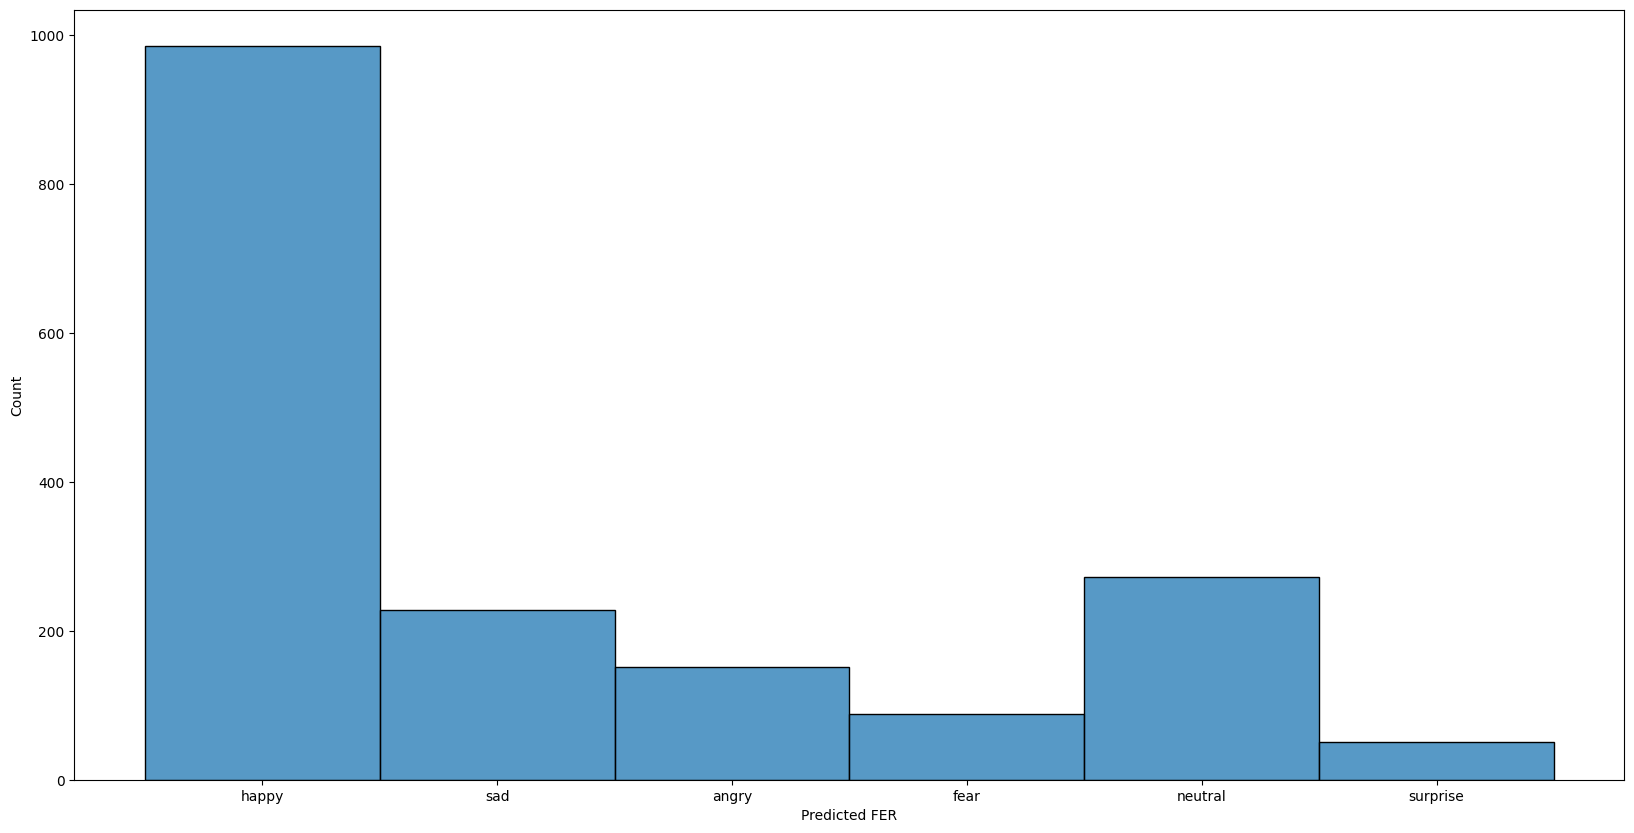

-------------------------------------------------------------------
Misclassification of Emotion  SAD


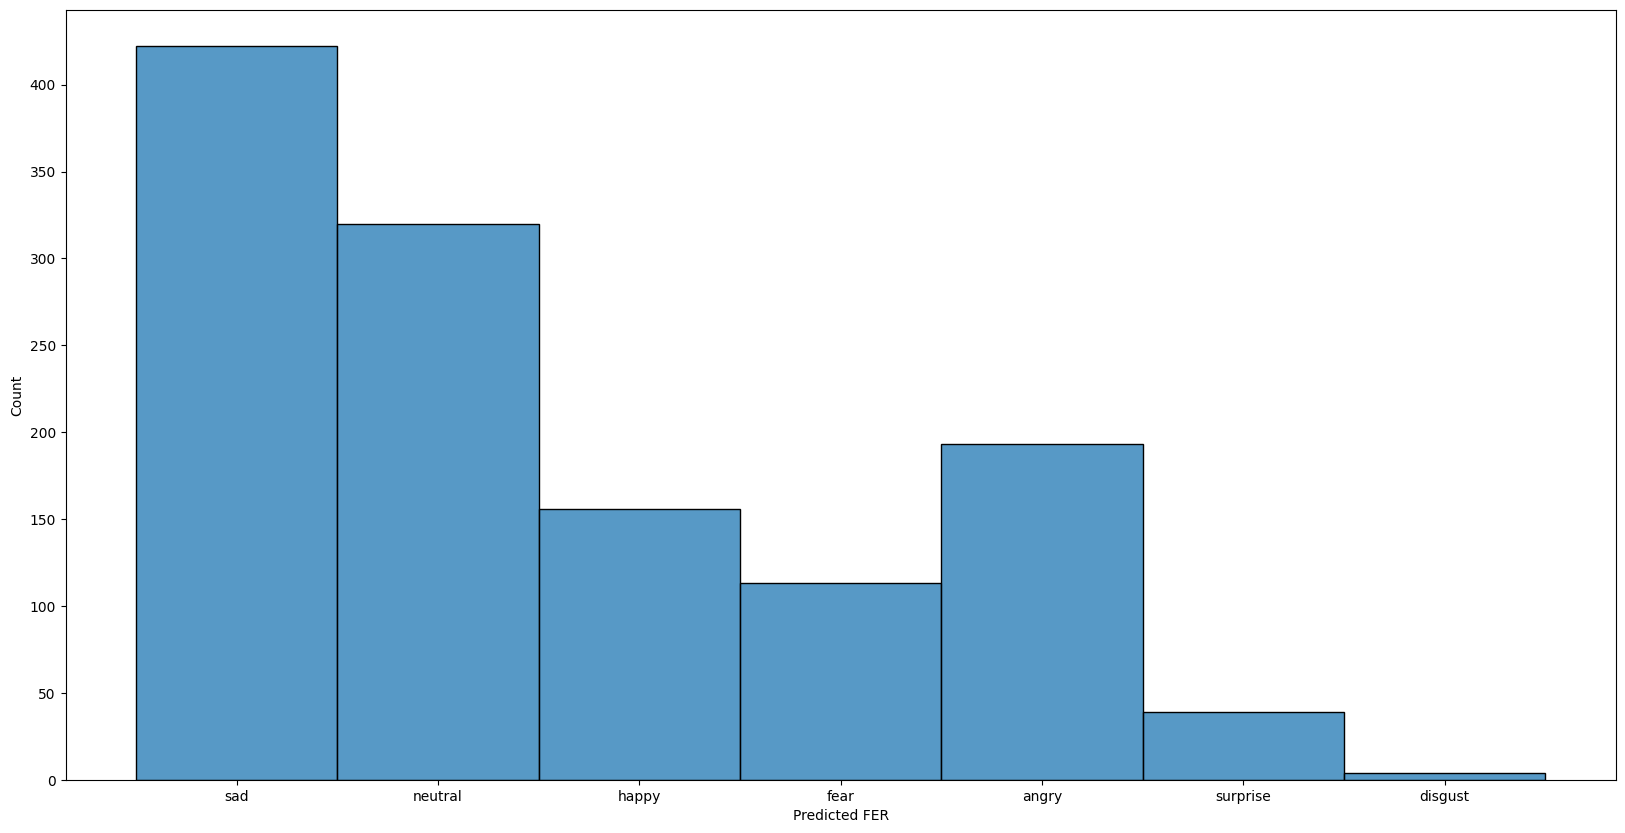

-------------------------------------------------------------------
Misclassification of Emotion  NEUTRAL


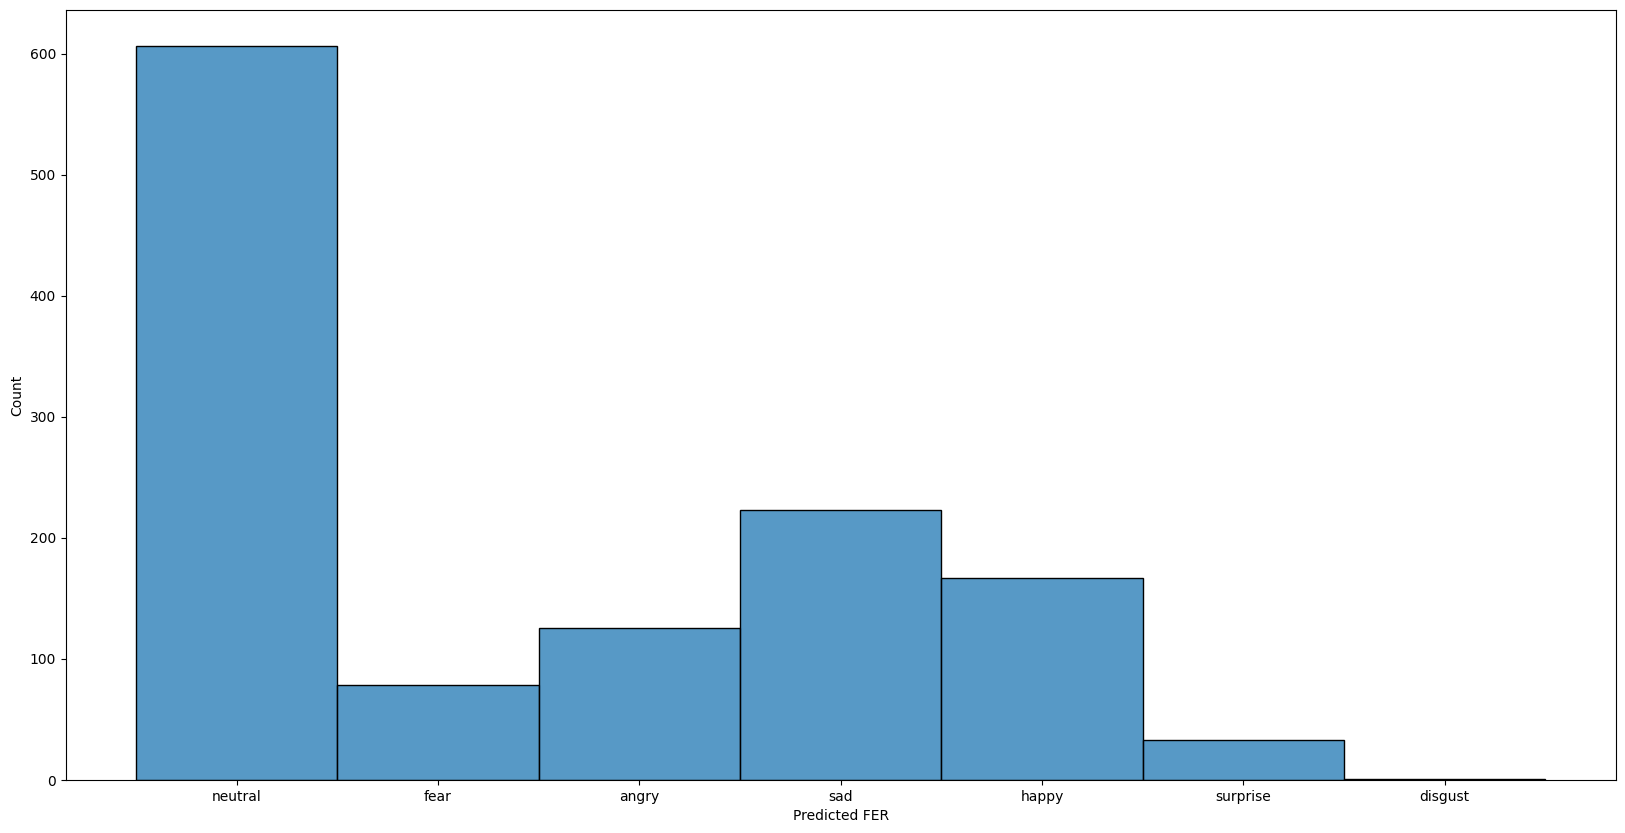

-------------------------------------------------------------------
Misclassification of Emotion  FEAR


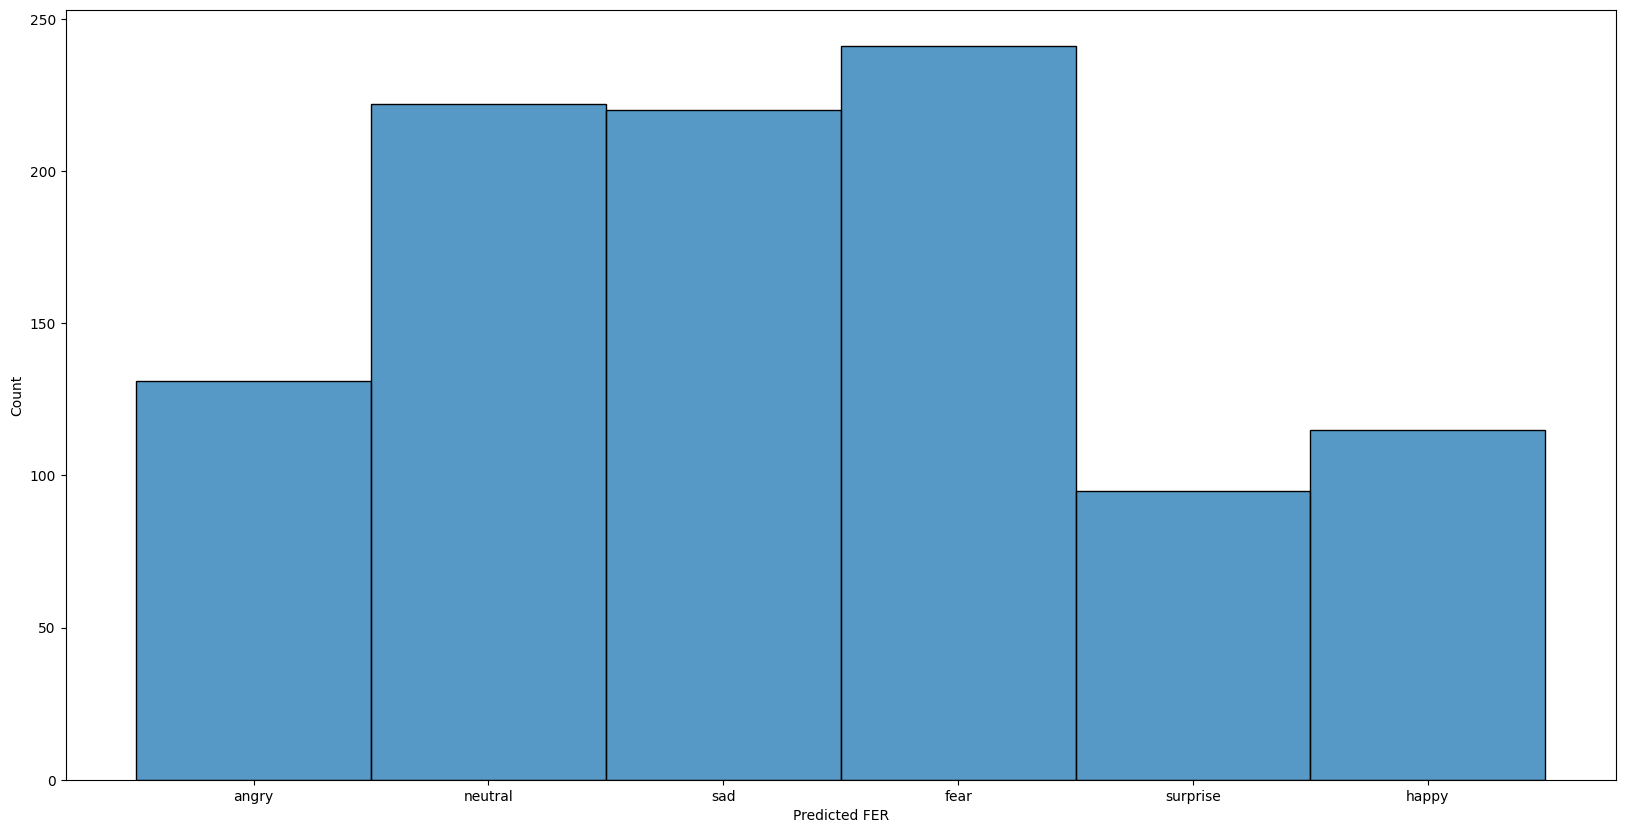

-------------------------------------------------------------------
Misclassification of Emotion  ANGRY


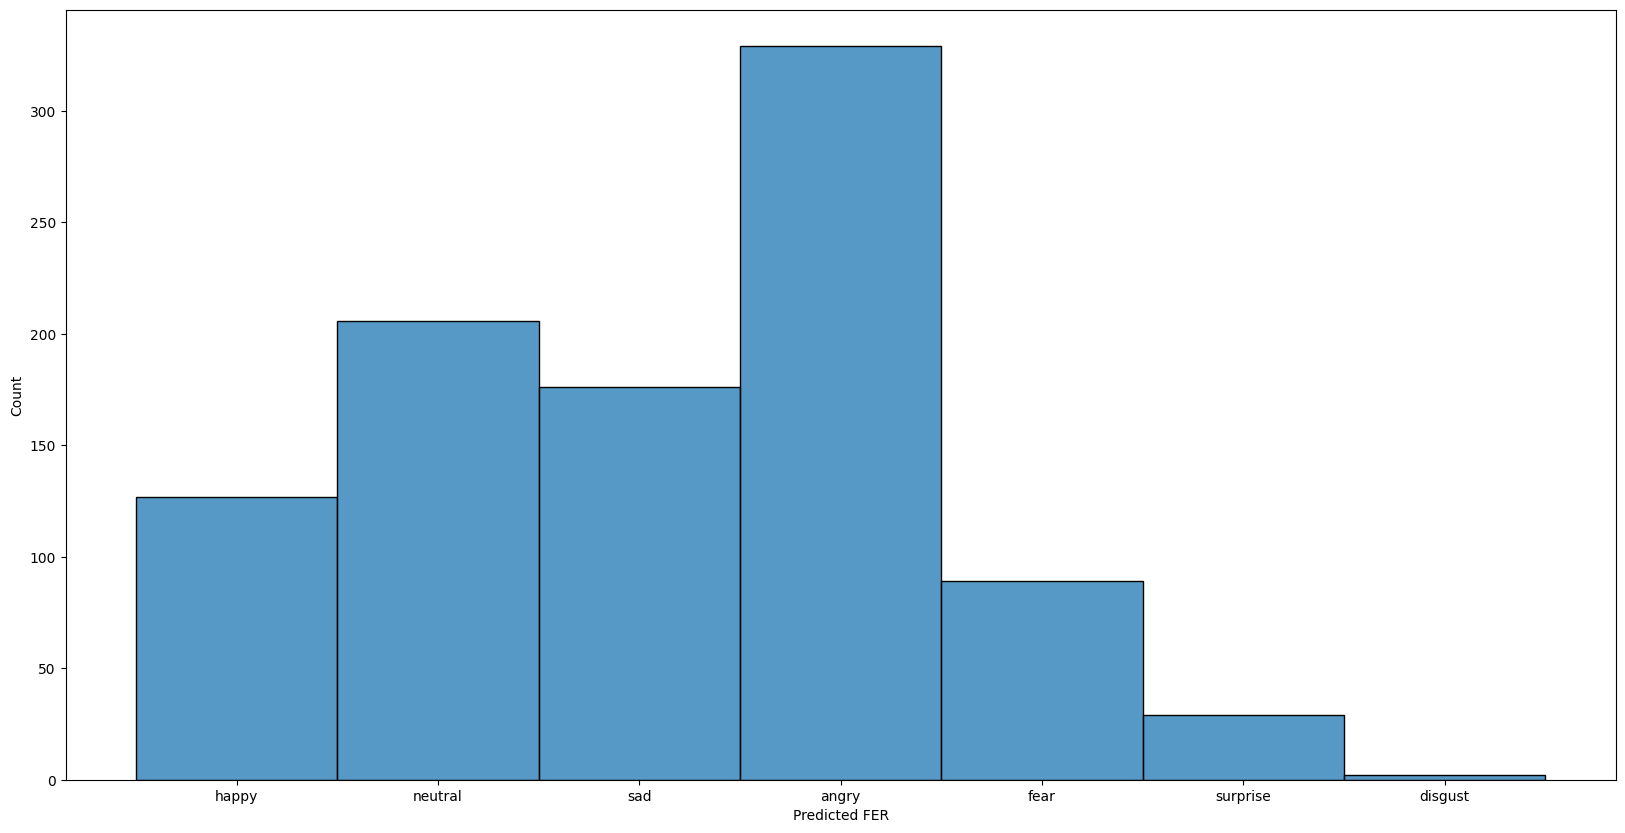

-------------------------------------------------------------------
Misclassification of Emotion  SURPRISE


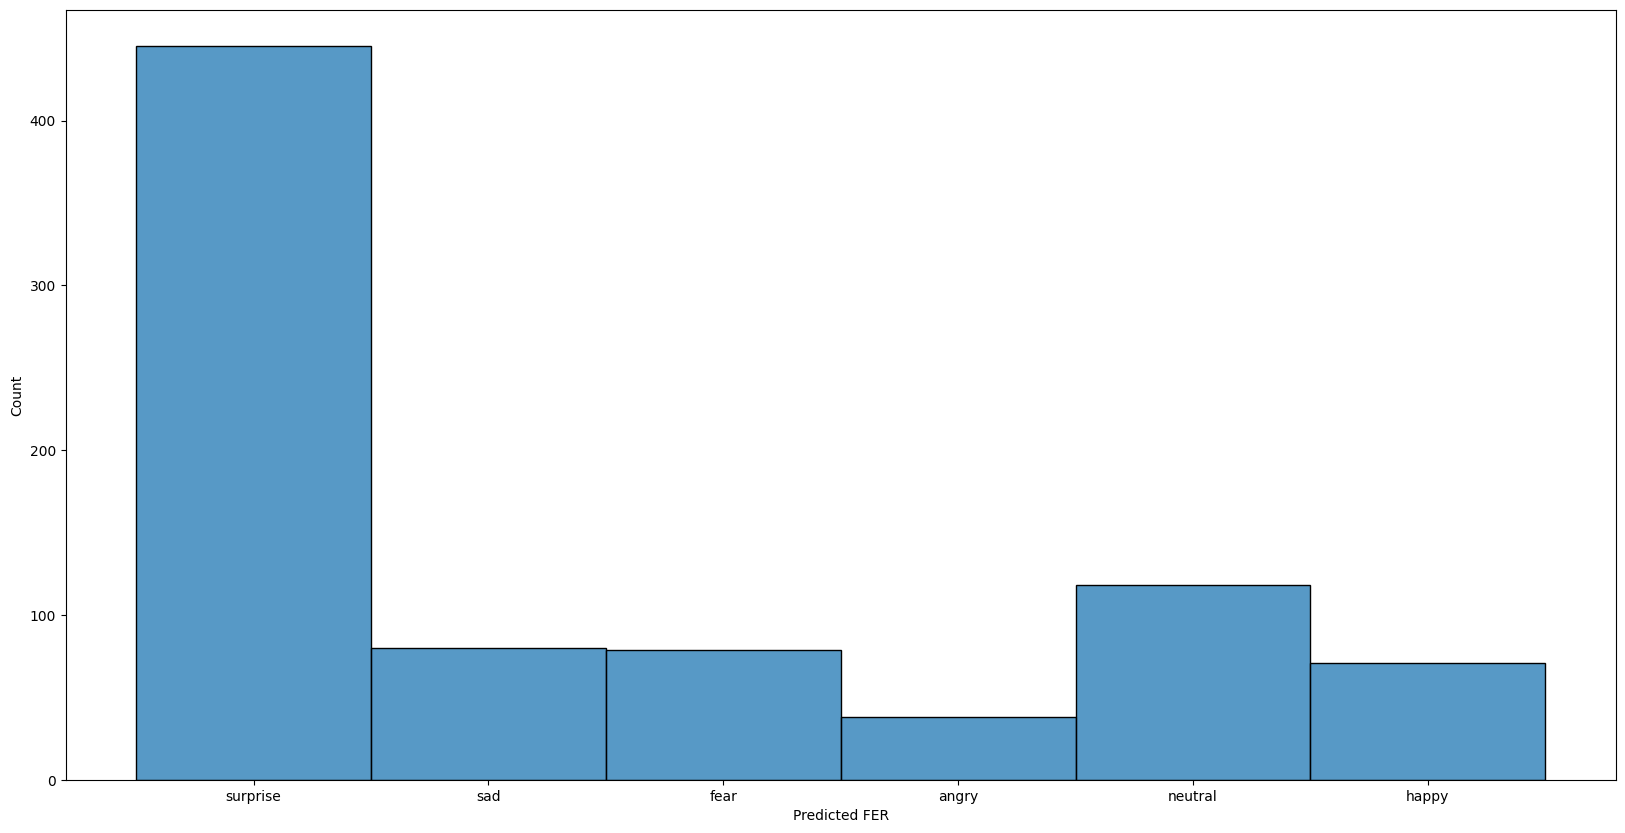

-------------------------------------------------------------------
Misclassification of Emotion  DISGUST


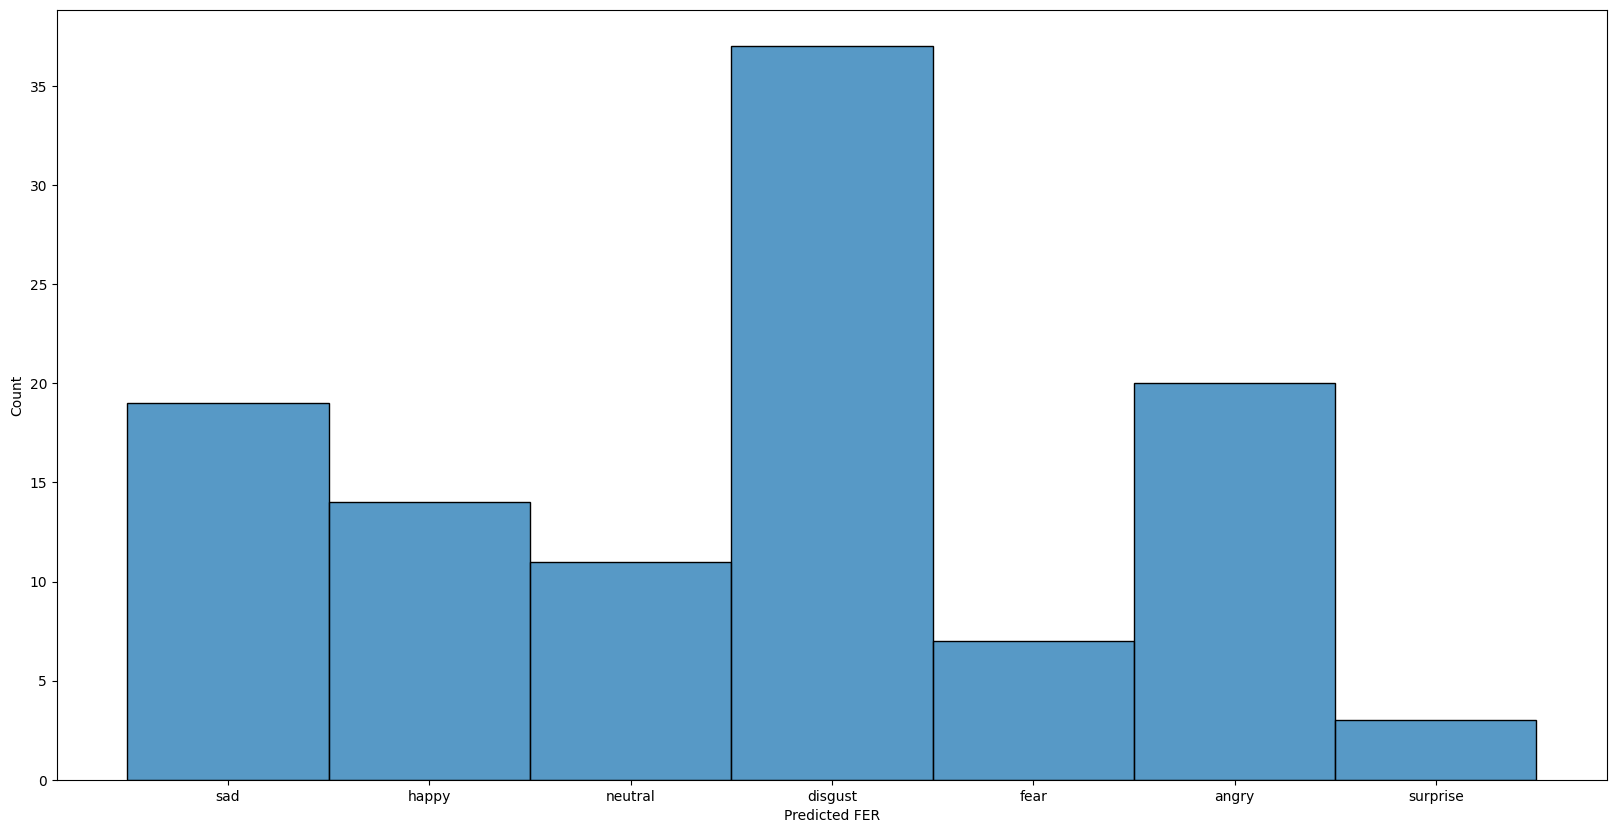

-------------------------------------------------------------------


In [53]:
for i in maps.keys():
    
    emotion = report[report['True FER']==i]

    print('Misclassification of Emotion ',i.upper())
    plt.figure(figsize=(20,10))
    sns.histplot(emotion['Predicted FER'])
    plt.show()
    print('-------------------------------------------------------------------')